In [2]:

%load_ext autoreload
%autoreload 2

from pl_trainer import LightningModule
from data_module import MNISTDataModule
from torchvision import transforms
import torch.nn as nn
import lightning.pytorch as pl
import pandas as pd
import matplotlib.pyplot as plt
import torch
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("PyTorch Version:", torch.__version__)

pl.seed_everything(42)

Seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA Available: True
CUDA Version: 11.8
PyTorch Version: 2.4.1+cu118


42

# Setting up Hyperparameters

In [3]:
lr = 0.001 # Change learning rate here
batch_size = 64
max_epochs = 5

# Setting up Optimizer

In [4]:
# optimizer = torch.optim.SGD # Change the optimizer here
optimizer = torch.optim.Adam

# Defining Model Architecture 

In [5]:
def create_model():
    """
        Initializes the model. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        # 3 Convolutional Blocks
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),  
        nn.ReLU(), 
        nn.MaxPool2d(kernel_size=2, stride=2),  

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  
        nn.ReLU(),  
        nn.MaxPool2d(kernel_size=2, stride=2),  

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  
        nn.ReLU(),  
        nn.MaxPool2d(kernel_size=2, stride=2),  

        nn.Flatten(),

        # Fully Connected Layers
        nn.Linear(4 * 4 * 128, 64), 
        nn.ReLU(), 
        nn.Linear(64, 10)  
    )

    return model

# Initialize the model, data module, and trainer
pl_model = LightningModule(model=create_model(), lr=lr, optimizer=optimizer)

# Setting up Dataloaders and Transformations

In [6]:
my_transforms = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])])


mnist_data = MNISTDataModule(batch_size=batch_size, transforms=my_transforms)

# Train Model

In [7]:
# Initialize CSVLogger
csv_logger = pl.loggers.CSVLogger(save_dir='logs/', name='mnist_logs', version=0)

# Set up the trainer
trainer = pl.Trainer(max_epochs=max_epochs, 
                     logger=csv_logger, 
                     check_val_every_n_epoch=1, 
                     enable_checkpointing=False,
                     deterministic=True)

# Train the model
trainer.fit(pl_model, mnist_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 6GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\tobia\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\fabric\loggers\csv_logs.py:268: Experiment logs directory logs/mnist_logs\version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | model   | Sequential         | 224 K  | train
1 | loss_fn | CrossEntropyLoss  

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\tobia\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\tobia\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 937/937 [00:20<00:00, 46.68it/s, v_num=0, val_acc=0.991, val_loss=0.0275]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 937/937 [00:20<00:00, 46.68it/s, v_num=0, val_acc=0.991, val_loss=0.0275]


# Plot Results

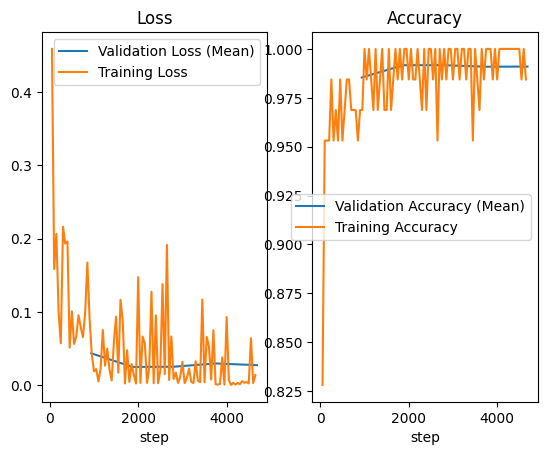

Final validation loss 0.0275
Final validation accuracy 0.991


In [8]:
df = pd.read_csv('logs/mnist_logs/version_0/metrics.csv')

# Create a figure and axes objects
fig, ax = plt.subplots(1,2)

# Plot 'val_loss' on the axes
df.dropna(subset=['val_loss']).plot(x='step', y='val_loss', ax=ax[0], label='Validation Loss (Mean)')
# Plot 'train_loss' on the same axes
df.dropna(subset=['train_loss']).plot(x='step', y='train_loss', ax=ax[0], label='Training Loss')

# Plot 'val_loss' on the axes
df.dropna(subset=['val_acc']).plot(x='step', y='val_acc', ax=ax[1], label='Validation Accuracy (Mean)')
# Plot 'train_loss' on the same axes
df.dropna(subset=['train_acc']).plot(x='step', y='train_acc', ax=ax[1], label='Training Accuracy')

ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.show()

print("Final validation loss", round(df['val_loss'].iloc[-1], 4))
print("Final validation accuracy", round(df['val_acc'].iloc[-1], 4))